In [1]:

import tensorflow as tf
import os
import numpy as np

from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications import resnet
from keras.layers import *
from keras.models import Model,Sequential
from keras import optimizers
from keras import regularizers
from scipy import spatial
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing import image
from skimage import color
from sklearn.model_selection import train_test_split

from keras import backend as K
K.clear_session()

In [2]:
img_size = 224

# Load the VGG16 model
vgg = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

for layers in vgg.layers:
    layers.trainable=False

print(vgg.output)

2022-05-23 15:59:39.538272: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


In [39]:
# we get data_path LOCAL
data_path = '/Users/luca/Desktop/dataset/'

classes_index = 0
label_list = []

class Dataset(object):
    def __init__(self, data_path):
        self.data_path = data_path
        assert os.path.exists(self.data_path), 'Insert a valid path!'

        # get class list
        self.data_classes = os.listdir(self.data_path)

        # init mapping dict
        self.data_mapping = {}

        # populate mapping dict
        for c, c_name in enumerate(self.data_classes):
            temp_path = os.path.join(self.data_path, c_name)
            temp_images = os.listdir(temp_path)

            for i in temp_images:
                img_tmp = os.path.join(temp_path, i)

                if img_tmp.lower().endswith(('.jpg', '.jpeg')):
                    if c_name == 'distractor':
                        self.data_mapping[img_tmp] = -1
                    else:
                        self.data_mapping[img_tmp] = c_name

        print('Loaded {:d} from {:s} images'.format(len(self.data_mapping.keys()),
                                                    self.data_path))
        
    def get_data_paths(self):
        # returns a list of imgpaths and related classes
        images = []
        classes = []
        for img_path in self.data_mapping.keys():
            if img_path.lower().endswith(('.jpg', '.jpeg')):
                images.append(img_path)
                classes.append(self.data_mapping[img_path])
        return images, np.array(classes)

    def get_data_images(self):
        t_size = (224,224,3)
        # returns a list of imgpaths and related classes      
        images = []
        for img_path in self.data_mapping.keys():
            if img_path.lower().endswith(('.jpg', '.jpeg')):
                img = image.load_img(img_path,target_size=t_size) 
                img = img_to_array(img)
                img = color.rgb2gray(img)
                images.append(img)
        return np.array(images)

    def get_data_classes(self, classes_index, label_list):
        # returns a list of imgpaths and related classes
        classes = []
        for img_path in self.data_mapping.keys():
            if img_path.lower().endswith(('.jpg', '.jpeg')):
                if self.data_mapping[img_path] in label_list:
                    classes.append(label_list.index(self.data_mapping[img_path]))
                else:
                    label_list.append(self.data_mapping[img_path])
                    classes.append(classes_index)
                    classes_index += 1
        print(label_list)
        return np.array(classes), classes_index

    def num_classes(self):
        # returns number of classes of the dataset
        return len(self.data_classes)

# we define training_path
training_path = os.path.join(data_path, 'training')

# we define validation path, query and gallery
validation_path = os.path.join(data_path, 'validation')
gallery_path = os.path.join(data_path, 'gallery')
query_path = os.path.join(data_path, 'query')


training_dataset = Dataset(data_path=training_path)
gallery_dataset = Dataset(data_path=gallery_path)
query_dataset = Dataset(data_path=query_path)

training_paths, training_classes = training_dataset.get_data_paths()

train = training_dataset.get_data_paths()

# we get validation gallery and query data

gallery_paths, gallery_classes = gallery_dataset.get_data_paths()
query_paths, query_classes = query_dataset.get_data_paths()

X = training_dataset.get_data_images()
y, classes_index = training_dataset.get_data_classes(classes_index=classes_index, label_list=label_list)

Xtrain, Xtest, ytrain, ytest = train_test_split(
        X, y, test_size=0.3, random_state=0)

Loaded 6355 from /Users/luca/Desktop/challenge_test_data/1 images
Loaded 65 from /Users/luca/Desktop/challenge_test_data/2 images


' X = training_dataset.get_data_images()\ny, classes_index = training_dataset.get_data_classes(classes_index=classes_index, label_list=label_list)\n\nXtrain, Xtest, ytrain, ytest = train_test_split(\n        X, y, test_size=0.3, random_state=0) '

In [4]:
import pandas as pd

train_y = training_classes
train_x = training_paths
test_x = gallery_paths

df = pd.DataFrame({'filename': train_x,
                  'category': train_y})

print(df.head())

                                            filename                category
0  /Users/luca/Desktop/dataset/training/n01644900...  n01644900(tailed_frog)
1  /Users/luca/Desktop/dataset/training/n01644900...  n01644900(tailed_frog)
2  /Users/luca/Desktop/dataset/training/n01644900...  n01644900(tailed_frog)
3  /Users/luca/Desktop/dataset/training/n01644900...  n01644900(tailed_frog)
4  /Users/luca/Desktop/dataset/training/n01644900...  n01644900(tailed_frog)


In [5]:
train_df, valid_df = train_test_split(df, test_size=0.25)
print(train_df.shape)
print(valid_df.shape)

(13267, 2)
(4423, 2)


In [6]:
# we extract the features of the train dataset
feature_list = []
for path in train_df['filename'].to_numpy():
    x = load_img(path,target_size=(img_size,img_size))
    img_array = img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    features = vgg.predict(img_array)
    feature_list.append(features)
    
feat_lst = np.reshape(feature_list,(-1,7*7*512))

In [7]:
del feature_list
print(feat_lst.shape)

(13267, 25088)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# split the data into training and validation sets
y = train_df['category'].to_numpy()  

X_train, X_test, y_train, y_test = train_test_split(feat_lst, y, test_size=0.2, random_state=2020)

# train the model
glm = LogisticRegression(C=0.1)
glm.fit(X_train,y_train)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

In [9]:
print("Accuracy on validation set using Logistic Regression: ",glm.score(X_test,y_test))

Accuracy on validation set using Logistic Regression:  0.953654860587792


In [10]:
print(feat_lst[0].shape)

(25088,)


In [11]:
# we get the test data
# Prendiamo le features dei test e li mettiamo in una matrice
testdf = pd.DataFrame({'filename': test_x})

gallery_matrix = []

for path in testdf['filename'].to_numpy():
    x = load_img(path,target_size=(img_size,img_size))
    img_array = img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    features = vgg.predict(img_array)
    features = np.reshape(features,25088)
    gallery_matrix.append(features)

# we get the query data
# Prendiamo le features dei query e li mettiamo in una matrice

querydf = pd.DataFrame({'filename': query_paths})

query_matrix = []

for path in querydf['filename'].to_numpy():
    x = load_img(path,target_size=(img_size,img_size))
    img_array = img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    features = vgg.predict(img_array)
    features = np.reshape(features,25088)
    query_matrix.append(features)

" # we get the test data\n# Prendiamo le features dei test e li mettiamo in una matrice\ntestdf = pd.DataFrame({'filename': test_x})\n\ngallery_matrix = []\n\nfor path in testdf['filename'].to_numpy():\n    x = load_img(path,target_size=(img_size,img_size))\n    img_array = img_to_array(x)\n    img_array = np.expand_dims(img_array, axis=0)\n    features = vgg.predict(img_array)\n    features = np.reshape(features,25088)\n    gallery_matrix.append(features)\n\n# we get the query data\n# Prendiamo le features dei query e li mettiamo in una matrice\n\nquerydf = pd.DataFrame({'filename': query_paths})\n\nquery_matrix = []\n\nfor path in querydf['filename'].to_numpy():\n    x = load_img(path,target_size=(img_size,img_size))\n    img_array = img_to_array(x)\n    img_array = np.expand_dims(img_array, axis=0)\n    features = vgg.predict(img_array)\n    features = np.reshape(features,25088)\n    query_matrix.append(features) "

In [13]:
print(len(gallery_matrix[0]))
print(len(query_matrix[0]))

' print(len(gallery_matrix[0]))\nprint(len(query_matrix[0])) '

In [40]:
import matplotlib.pyplot as plt

query_img = query_dataset.get_data_images()
query_labels, classes_index = query_dataset.get_data_classes(classes_index=classes_index, label_list=label_list)

gallery_img = gallery_dataset.get_data_images()
gallery_labels, classes_index = gallery_dataset.get_data_classes(classes_index=classes_index, label_list=label_list)

['query']
['query', 'gallery']


In [ ]:
from scipy.spatial import distance_matrix
from scipy import spatial

# we compute the distance matrix
matrix = []

for i in range(len(query_matrix)):
    list = []
    for j in range(len(gallery_matrix)):
        list.append(1 - spatial.distance.cosine(query_matrix[i],gallery_matrix[j]))
    matrix.append(list)

rank = tf.math.top_k(
    matrix, k=10, sorted=True, name=None
)



In [41]:
querydf = pd.DataFrame({'filename': query_paths})
gallerydf = pd.DataFrame({'filename': gallery_paths})

def get_images(df, img_size):
    images = []
    for path in df['filename'].to_numpy():
        x = load_img(path,target_size=(img_size,img_size))
        img_array = img_to_array(x)
        img_array = np.expand_dims(img_array, axis=0)
        images.append(img_array)
    return images

In [42]:
query_imgs = get_images(querydf, img_size)
gallery_imgs = get_images(gallerydf, img_size)

In [ ]:
import requests
import json


def submit(results, url="http://coruscant.disi.unitn.it:3001/results/"):
    res = json.dumps(results)
    response = requests.post(url, res)
    try:
        result = json.loads(response.text)
        print(f"accuracy is {result['results']}")
    except json.JSONDecodeError:
        print(f"ERROR: {response.text}")

In [149]:
from scipy import spatial
from pathlib import Path

top1 = 0
top5 = 0
top10 = 0
non_top = 0

res = dict()
mydata = dict()
mydata['groupname'] = "Marko Arnautovic"

gallery_features = []

for i in range (len(gallery_imgs)):

    gf = vgg.predict(gallery_imgs[i])
    gf = np.reshape(gf,25088)
    gallery_features.append(gf)


for idx in range(len(query_paths)):
    
    query_features = []

    query_features = vgg.predict(query_imgs[idx])
    query_features = np.reshape(query_features,25088)

    distances = []
    np.set_printoptions(suppress=True)
    for i in range (len(gallery_imgs)):
        d = 1-spatial.distance.cosine(query_features, gallery_features[i])
        distances.append([d, i])

    distances.sort(reverse=True)
    top_ten = distances[:10]

    temp = []
    for j in range(10):
        path=Path(gallery_paths[top_ten[j][1]])
        temp.append(path.name)
    qpath = Path(query_paths[idx])
    res[qpath.name] = temp
        
mydata["images"] = res
print(mydata)
#submit(mydata)

In [ ]:
query_idx = 3

print("Query: " + query_paths[query_idx])
img = image.load_img(query_paths[query_idx])
plt.imshow(img)

plt.figure(figsize=(50, 50))
temp = mydata['images']
t = temp[query_paths[query_idx]]
for i in range(10):
    ax = plt.subplot(2,5, i + 1)
    img = image.load_img(str(t[i]))
    plt.imshow(img)
    plt.axis("off")

Query number 14 has no top-10 appearences
Query number 39 has no top-10 appearences
Query number 78 has no top-10 appearences
top1: 90
top5: 6
top10: 1
Non top: 3
100
top1: 90.0%
top5: 96.0%
top10: 97.0%


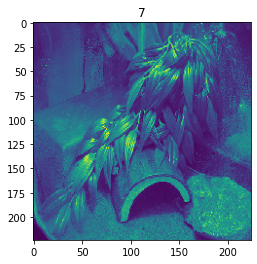

In [ ]:
top1 = 0
top5 = 0
top10 = 0
non_top = 0
for j in range (len(query_img)):   
    q_label = int(query_labels[j])
    isthere = False
    for k in range (10):
        if int(gallery_labels[rank[1][j][k]]) == q_label:
            isthere = True
            if (k+1) == 1:
                top1+=1
                break
            elif (k+1) <=5:
                top5+=1
                break
            elif (k+1) <= 10:
                top10+=1
                break
    if not isthere:
        non_top +=1
        plt.imshow(query_img[j])
        plt.title(int(query_labels[j]))
        print(f"Query number {j} has no top-10 appearences")
        
            
print("top1: "+ str(top1))
print("top5: "+ str(top5))
print("top10: "+ str(top10))
print("Non top: " + str(non_top))
top1 = top1/len(query_img)*100
top5 = top5/len(query_img)*100 + top1
top10 = top10/len(query_img)*100 + top5
print(len(query_img))
print("top1: " + str(top1) + "%")
print("top5: " + str(top5)+ "%")
print("top10: " + str(top10)+ "%")

In [ ]:
def prepare_dict(query_img, gallery_img, rank):
    res = dict()
    for i in range(len(query_img)):
        res[query_img[i]] = [gallery_img[rank[1][i][j]] for j in range(10)]
    return res